<a href="https://colab.research.google.com/github/Kritikargv17/DL_LAB_500120185_KRITIKA_RAGHAV/blob/main/Exp11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pushkar007/vaihingendataann")

print("Path to dataset files:", path)

100%|██████████| 7.05M/7.05M [00:00<00:00, 34.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pushkar007/vaihingendataann/versions/1


Using: cpu
Using Colab cache for faster access to the 'vaihingendataann' dataset.
ANNOTATION PATH: /kaggle/input/vaihingendataann
Using Colab cache for faster access to the 'vaihingendataimg' dataset.
IMAGE PATH: /kaggle/input/vaihingendataimg
Detected IMAGE DIR: /kaggle/input/vaihingendataimg/img_dir
Detected MASK DIR : /kaggle/input/vaihingendataann/ann_dir
FINAL IMG_DIR: /kaggle/input/vaihingendataimg/img_dir/train
FINAL MASK_DIR: /kaggle/input/vaihingendataann/ann_dir/train
Total Pairs: 344
Train pairs: 292
Val pairs: 52
Epoch 1/20 | Train Loss: 1.5911 | Val Loss: 1.5683 | Train Dice: 0.0000 | Val Dice: 0.0000
Epoch 2/20 | Train Loss: 1.5013 | Val Loss: 1.4852 | Train Dice: 0.0000 | Val Dice: 0.0000
Epoch 3/20 | Train Loss: 1.4718 | Val Loss: 1.4698 | Train Dice: 0.0000 | Val Dice: 0.0000
Epoch 4/20 | Train Loss: 1.4503 | Val Loss: 1.4491 | Train Dice: 0.0000 | Val Dice: 0.0000
Epoch 5/20 | Train Loss: 1.4307 | Val Loss: 1.4332 | Train Dice: 0.0000 | Val Dice: 0.0000
Epoch 6/20 | T

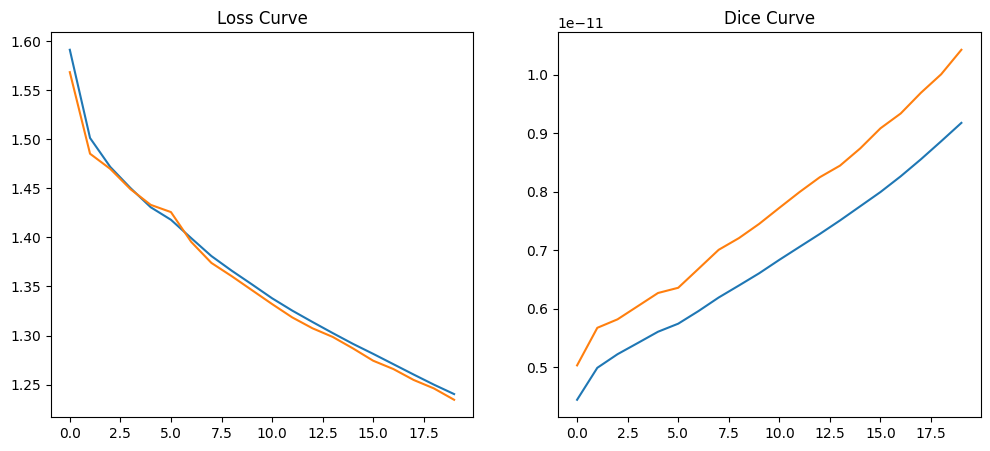

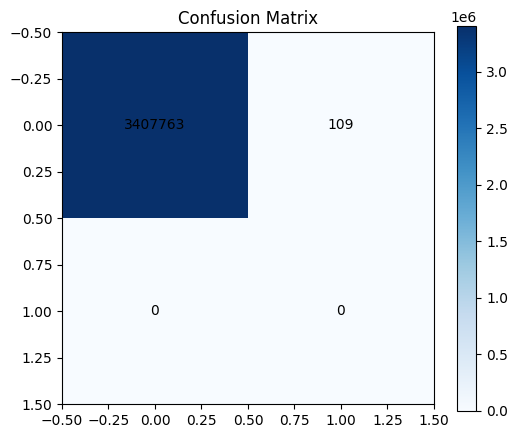

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


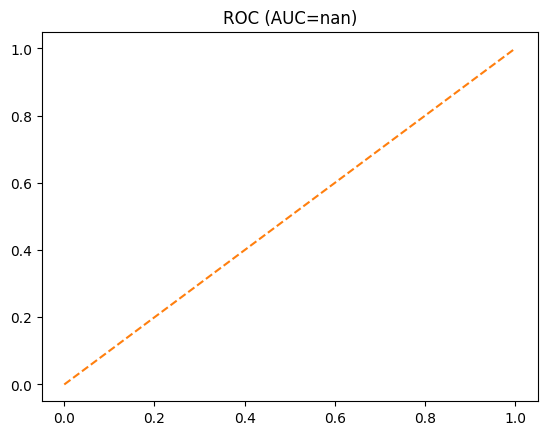

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


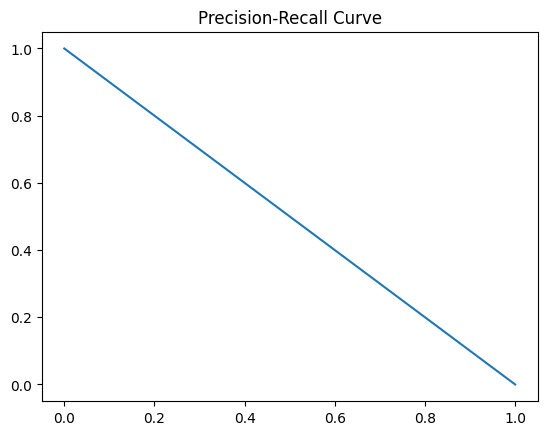

In [6]:
!pip install -q kagglehub albumentations opencv-python scikit-learn matplotlib torch torchvision torchaudio

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools
import random
import torchvision.transforms.functional as TF

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

# ============================================================
# 1) DOWNLOAD DATASETS FROM KAGGLE USING KAGGLEHUB
# ============================================================
print("Downloading annotations...")
ann_path = kagglehub.dataset_download("pushkar007/vaihingendataann")
print("ANNOTATION PATH:", ann_path)

print("Downloading images...")
img_path = kagglehub.dataset_download("pushkar007/vaihingendataimg")
print("IMAGE PATH:", img_path)

def find_dir(base, keywords):
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if any(k.lower() in d.lower() for k in keywords):
                return os.path.join(root, d)
    return None

MASK_DIR = find_dir(ann_path, ["ann", "mask"])
IMG_DIR  = find_dir(img_path, ["img", "rgb", "images"])

print("Detected IMAGE DIR:", IMG_DIR)
print("Detected MASK DIR :", MASK_DIR)

# If train subfolder exists
if os.path.isdir(os.path.join(IMG_DIR, "train")):
    IMG_DIR = os.path.join(IMG_DIR, "train")
if os.path.isdir(os.path.join(MASK_DIR, "train")):
    MASK_DIR = os.path.join(MASK_DIR, "train")

print("FINAL IMG_DIR:", IMG_DIR)
print("FINAL MASK_DIR:", MASK_DIR)

# ============================================================
# 2) PAIR IMAGES & MASKS
# ============================================================
img_files = sorted(glob(os.path.join(IMG_DIR, "*")))
mask_files = sorted(glob(os.path.join(MASK_DIR, "*")))

img_stems  = {Path(p).stem: p for p in img_files}
mask_stems = {Path(p).stem: p for p in mask_files}

common = sorted(set(img_stems.keys()) & set(mask_stems.keys()))
pairs = [(img_stems[s], mask_stems[s]) for s in common]

print("Total Pairs:", len(pairs))

# Split
random.shuffle(pairs)
split = int(0.85 * len(pairs))
train_pairs = pairs[:split]
val_pairs   = pairs[split:]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))

# ============================================================
# 3) PYTORCH DATASET
# ============================================================
IMAGE_SIZE = 256

class SegDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = (mask > 127).astype(np.float32)

        img = img.astype(np.float32) / 255.

        # Removed redundant np.transpose
        img = torch.tensor(img).permute(2,0,1)  # CHW

        mask = torch.tensor(mask).unsqueeze(0)

        return img.float(), mask.float()

train_ds = SegDataset(train_pairs)
val_ds   = SegDataset(val_pairs)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

# ============================================================
# 4) PYTORCH U-NET MODEL
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        self.enc4 = ConvBlock(128, 256)
        self.bottom = ConvBlock(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec1 = ConvBlock(512+256, 256)
        self.dec2 = ConvBlock(256+128, 128)
        self.dec3 = ConvBlock(128+64, 64)
        self.dec4 = ConvBlock(64+32, 32)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)

        bn = self.bottom(p4)

        d1 = self.up(bn)
        d1 = torch.cat([d1, c4], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up(d1)
        d2 = torch.cat([d2, c3], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up(d2)
        d3 = torch.cat([d3, c2], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up(d3)
        d4 = torch.cat([d4, c1], dim=1)
        d4 = self.dec4(d4)

        return torch.sigmoid(self.out(d4))

model = UNet().to(DEVICE)

# ============================================================
# 5) LOSS + DICE
# ============================================================
bce = nn.BCELoss()

def dice_coef(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return (2*inter + eps) / (pred.sum() + target.sum() + eps)

def loss_fn(pred, mask):
    return bce(pred, mask) + (1 - dice_coef(pred, mask))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ============================================================
# 6) TRAINING LOOP
# ============================================================
train_losses, val_losses = [], []
train_dice, val_dice = [], []

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    epoch_loss, epoch_dice = 0,0

    for img, mask in train_loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)

        pred = model(img)
        loss = loss_fn(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coef(pred, mask).item()

    train_losses.append(epoch_loss/len(train_loader))
    train_dice.append(epoch_dice/len(train_loader))

    # Validation
    model.eval()
    v_loss, v_dice = 0,0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            pred = model(img)

            v_loss += loss_fn(pred, mask).item()
            v_dice += dice_coef(pred, mask).item()

    val_losses.append(v_loss/len(val_loader))
    val_dice.append(v_dice/len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Dice: {train_dice[-1]:.4f} | Val Dice: {val_dice[-1]:.4f}")

# ============================================================
# 7) PLOT TRAINING CURVES
# ============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses); plt.plot(val_losses)
plt.title("Loss Curve")
plt.subplot(1,2,2)
plt.plot(train_dice); plt.plot(val_dice)
plt.title("Dice Curve")
plt.show()

# ============================================================
# 8) CONFUSION MATRIX, ROC, PR CURVE
# ============================================================
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for img, mask in val_loader:
        img = img.to(DEVICE)
        pred = model(img).cpu().numpy().flatten()
        y_pred.extend(pred)
        y_true.extend(mask.numpy().flatten())

y_pred_bin = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_bin)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
for i, j in itertools.product(range(2), range(2)):
    plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC (AUC={roc_auc:.3f})")
plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_true, y_pred)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.show()